In [1]:

!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=14nb6pcG__i34dJxPSAV737QQivQ-TgAE' -O gdrive_atac0.h5ad


!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=19-8dzYezWrp34XnrYt_tgvi07ias6OxP' -O gdrive_atac1.h5ad


!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1g2YDTrhfLXoEpQNMe5rZswMlY4y5Z8IV' -O gdrive_atac2.h5ad

# !wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1vn530Jt5uJJE7oGHTNK6sb44LlQ018Vr' -O gdrive_rna.h5ad


/bin/bash: /home/ubuntu0/miniconda3/envs/scbasset/lib/libtinfo.so.6: no version information available (required by /bin/bash)
--2024-02-11 05:31:26--  https://docs.google.com/uc?export=download&id=14nb6pcG__i34dJxPSAV737QQivQ-TgAE
Resolving docs.google.com (docs.google.com)... 142.251.37.14, 2a00:1450:4005:802::200e
Connecting to docs.google.com (docs.google.com)|142.251.37.14|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=14nb6pcG__i34dJxPSAV737QQivQ-TgAE&export=download [following]
--2024-02-11 05:31:26--  https://drive.usercontent.google.com/download?id=14nb6pcG__i34dJxPSAV737QQivQ-TgAE&export=download
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 142.251.209.129, 2a00:1450:4005:801::2001
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|142.251.209.129|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 27836424 (27M) [applica

In [1]:
import anndata as ad 
import os
import pandas as pd 
import scglue 
import scanpy as sc 
#generate rna


#generate rna 
# rna = ad.read_h5ad('/home/ubuntu0/scBasset/Chen-2019-RNA.h5ad')
# rna.layers["counts"] = rna.X.copy()

# #select high expressive genes as in the tutorial the number 2000
# sc.pp.highly_variable_genes(rna, n_top_genes=60000, flavor="seurat_v3")

# sc.pp.normalize_total(rna)
# sc.pp.log1p(rna)
# sc.pp.scale(rna)
# sc.tl.pca(rna, n_comps=100, svd_solver="auto")

# sc.pp.neighbors(rna, metric="cosine")
# sc.tl.umap(rna)
# sc.pl.umap(rna,color='cell_type')

# scglue.data.get_gene_annotation(
#     rna, gtf="/home/ubuntu0/GLUE/evaluation/workflow/scripts/gencode.vM25.chr_patch_hapl_scaff.annotation.gtf.gz",
#     gtf_by="gene_name"
# )
rna=ad.read_h5ad('unfiltered_rna.h5ad')
atacl=[]
atacl.append(ad.read_h5ad('gdrive_atac0.h5ad'))
atacl.append(ad.read_h5ad('gdrive_atac1.h5ad'))
atacl.append(ad.read_h5ad('gdrive_atac2.h5ad'))

/home/ubuntu0/miniconda3/envs/glue2_scib/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#get atac0,atac1,atac2
path='400ep/'

guidancel=[]
for i in range(3):
    atac=atacl[i]
    scglue.data.lsi(atac, n_components=100, n_iter=15)#enable lsi embedding
    split = atac.var_names.str.split(r"[:-]")
    atac.var["chrom"] = atac.var['chr']
    atac.var["chromStart"] = atac.var['start']
    atac.var["chromEnd"] = atac.var['end']
    guidance=scglue.genomics.rna_anchored_guidance_graph(rna, atac)
    atac.obsm['proj']=pd.read_csv(path+'scbem'+str(i)+'.csv',index_col=0).values #add scbasset embedding
    guidancel.append(guidance)
    atac.write_h5ad(path+'data/embedatac'+str(i)+'.h5ad')#contain lsi and scb
    
sc.pp.subsample(rna,n_obs=4000,random_state=42) #filter rna here 

/home/ubuntu0/miniconda3/envs/glue2_scib/lib/python3.8/site-packages/scglue/num.py:289: RuntimeWarning: divide by zero encountered in divide
  idf = X.shape[0] / X.sum(axis=0)
window_graph: 100%|██████████████████████████████████████████████████████████████████| 28930/28930 [00:01<00:00, 28444.41it/s]
/home/ubuntu0/miniconda3/envs/glue2_scib/lib/python3.8/site-packages/scglue/num.py:289: RuntimeWarning: divide by zero encountered in divide
  idf = X.shape[0] / X.sum(axis=0)
window_graph: 100%|██████████████████████████████████████████████████████████████████| 28930/28930 [00:00<00:00, 53727.25it/s]
/home/ubuntu0/miniconda3/envs/glue2_scib/lib/python3.8/site-packages/scglue/num.py:289: RuntimeWarning: divide by zero encountered in divide
  idf = X.shape[0] / X.sum(axis=0)
window_graph: 100%|██████████████████████████████████████████████████████████████████| 28930/28930 [00:00<00:00, 53364.95it/s]


In [3]:
rna.write_h5ad(path+'data/filtered_rna.h5ad')

In [4]:
import scglue
from itertools import chain
import networkx as nx 
def train_glue(rna,atac,input_representation,guidance):
     
    #pca rna and lsi atac
    scglue.models.configure_dataset(rna,'NB',use_highly_variable=True,use_layer='counts',use_rep='X_pca')

    scglue.models.configure_dataset(atac,'NB',use_highly_variable=True,use_rep=input_representation)

    guidance_hvf=guidance.subgraph(chain(rna.var.query('highly_variable').index,atac.var.query('highly_variable').index)).copy()

    glue=scglue.models.fit_SCGLUE({'rna':rna,'atac':atac},guidance_hvf,fit_kws={'directory':'glue'})
    return glue,guidance_hvf


In [5]:
import os 
os.makedirs(path+'glue')

In [4]:
import warnings 
warnings.filterwarnings('ignore')
import seaborn as sns
import matplotlib.pyplot as plt 
import pandas as pd 

def metric_ari(atac,rep):
    import scib
    sc.pp.neighbors(atac, use_rep=rep)
    scib.me.cluster_optimal_resolution(atac, cluster_key="cluster", label_key="cell_type")
    return scib.me.ari(atac, cluster_key="cluster", label_key="cell_type")

def metric_nmi(atac,rep):
    import scib
    scib.me.cluster_optimal_resolution(atac, cluster_key="cluster", label_key="cell_type")
    return scib.me.nmi(atac, cluster_key="cluster", label_key="cell_type")

def run_scib2(atac,proj):
    import scib
    import pandas as pd
    atac.obs['cell_type']=atac.obs['cell_type'].astype('category')
    atac.obs['batch']=0
    atac.obs['batch']=atac.obs['batch'].astype('category')
    out={}
    out.update({'ari': metric_ari(atac,proj),
           'nmi': metric_nmi(atac,proj),
            'isolated_labels_aws':scib.me.isolated_labels_asw(atac, batch_key="batch", label_key="cell_type", embed=proj),
            'isolated_labels_f1':scib.me.isolated_labels_f1(atac, batch_key="batch", label_key="cell_type",embed='X_glue'),
            'silhouette':scib.me.silhouette(atac, label_key="cell_type", embed="X_glue"),
            'clisi':scib.me.clisi_graph(atac, label_key="cell_type", type_='embed',use_rep=proj)
           })
    out = {k:[v] for k,v in out.items()} 
    out = pd.DataFrame(out)
    out.loc[:,'bio']=out.mean(1)
    return out

def run_scib(atac,proj):
    import scib
    clisi=False
    ilisi=False
    graph_connect=False
    hvg=False
    atac.obs['cell_type']=atac.obs['cell_type'].astype('category')
    atac.obs['batch']=0
    atac.obs['batch']=atac.obs['batch'].astype('category')
    out=scib.metrics.metrics(atac, atac, batch_key='batch', label_key='cell_type', embed=proj, cluster_key='cluster', cluster_nmi=None, ari_=True, nmi_=True, nmi_method='arithmetic', nmi_dir=None, silhouette_=True, si_metric='euclidean', pcr_=True, cell_cycle_=False, organism='human', hvg_score_=hvg, isolated_labels_=True, isolated_labels_f1_=False, isolated_labels_asw_=True, n_isolated=True, graph_conn_=graph_connect, trajectory_=False, kBET_=False, lisi_graph_=False, ilisi_=ilisi, clisi_=clisi, subsample=0.5, n_cores=1, type_=None, verbose=False)
    out.loc['clisi',:]=scib.me.clisi_graph(atac, label_key="cell_type", type_='embed',use_rep=proj)
    return out

def metric_res(dflist,data_namelist):
    gmetrics=pd.concat(dflist,axis='rows')
    gmetrics=gmetrics.set_axis(data_namelist,axis='rows')

    # bio=gmetrics.loc[['NMI_cluster/label','ARI_cluster/label','ASW_label','cell_cycle_conservation','isolated_label_F1','isolated_label_silhouette','hvg_overlap','trajectory'],:,]
    # bio=bio.T
    # bio=bio.drop(columns=['hvg_overlap','trajectory','cell_cycle_conservation'])
    # #bio mean 
    # bio['bio']=bio.mean(axis=1)
    bio_style=gmetrics.style.background_gradient(cmap = 'Blues')
    return gmetrics,bio_style


def plot_dx(dx_lsi,dx_scb,save_pth):

    fig,ax=plt.subplots(1,2,figsize=(20,6),gridspec_kw={'wspace':0.9})
    sub=sns.lineplot(x='n_meta',y='consistency',data=dx_lsi,ax=ax[0],label='baseline').axhline(y=0.05,c='darkred',ls='--')
    ax[0].set_title('baseline consistency score')
    ax[0].get_legend().remove()
    sns.lineplot(x='n_meta',y='consistency',data=dx_scb,ax=ax[1],label='scglue with scbasset embedding(input)').axhline(y=0.05,c='darkred',ls='--')
    ax[1].set_title('scglue3_scbasset consistency score')
    ax[1].get_legend().remove()

    plt.savefig(save_pth)
    
def plot_dx_together(dx_lsi,dx_scb,save_pth):
    dx_list=[]
    dx_list.append(dx_lsi.T)
    dx_list.append(dx_scb.T)
    dx_metrics = pd.concat(dx_list,axis='rows')
    dx_metrics = dx_metrics.T
    dx_metrics = dx_metrics.iloc[:,[0,1,3]]
    dx_metrics = dx_metrics.set_axis(['n_meta cells','baseline consistency','scglue3_scbasset consistency'],axis='columns')
    dx_metrics = dx_metrics.set_index('n_meta cells')
    ax=dx_metrics.plot(figsize=(8,6))
    ax.set_ylabel('consistency')
    ax.set_xlabel('n-meta cells')
    plt.title('scglue consistency score metrics')
    plt.savefig(save_pth)

In [8]:
os.makedirs(path+'hvfguidance',exist_ok=True)

In [9]:
# path='2024-01-31-22_55_35'
# bio_result=[]
# name_list=[]
# for i in range(3):# to train glue embedding
#     atac=atacl[i]
#     guidance=guidancel[i]
    
#     glue_scb,guidance_hvf_scb=train_glue(rna,atac,'proj',guidance)
#     glue_scb.save(path+'glue/scb'+str(i)+'.dill')
#     nx.write_graphml(guidance_hvf_scb,path+'hvfguidance/'+'hvfscb'+str(i))
    
#     glue_lsi,guidance_hvf_lsi=train_glue(rna,atac,'X_lsi',guidance)
#     glue_lsi.save(path+'glue/lsi'+str(i)+'.dill')
#     nx.write_graphml(guidance_hvf_lsi,path+'hvfguidance/'+'hvflsi'+str(i))
    


[INFO] fit_SCGLUE: Pretraining SCGLUE model...
[INFO] autodevice: Using GPU 0 as computation device.
[INFO] check_graph: Checking variable coverage...
[INFO] check_graph: Checking edge attributes...
[INFO] check_graph: Checking self-loops...
[INFO] check_graph: Checking graph symmetry...
[INFO] SCGLUEModel: Setting `graph_batch_size` = 49939
[INFO] SCGLUEModel: Setting `max_epochs` = 427
[INFO] SCGLUEModel: Setting `patience` = 36
[INFO] SCGLUEModel: Setting `reduce_lr_patience` = 18
[INFO] SCGLUETrainer: Using training directory: "glue/pretrain"
[INFO] SCGLUETrainer: [Epoch 10] train={'g_nll': 0.444, 'g_kl': 0.001, 'g_elbo': 0.445, 'x_rna_nll': 0.115, 'x_rna_kl': 0.002, 'x_rna_elbo': 0.117, 'x_atac_nll': 0.055, 'x_atac_kl': 0.001, 'x_atac_elbo': 0.056, 'dsc_loss': 0.692, 'vae_loss': 0.191, 'gen_loss': 0.156}, val={'g_nll': 0.44, 'g_kl': 0.002, 'g_elbo': 0.442, 'x_rna_nll': 0.116, 'x_rna_kl': 0.002, 'x_rna_elbo': 0.118, 'x_atac_nll': 0.058, 'x_atac_kl': 0.001, 'x_atac_elbo': 0.058, 'ds

2024-02-01 20:02:33,988 ignite.handlers.early_stopping.EarlyStopping INFO: EarlyStopping: Stop training


[INFO] EarlyStopping: Restoring checkpoint "98"...
[INFO] EarlyStopping: Restoring checkpoint "98"...
[INFO] fit_SCGLUE: Estimating balancing weight...
[INFO] estimate_balancing_weight: Clustering cells...
[INFO] estimate_balancing_weight: Matching clusters...
[INFO] estimate_balancing_weight: Matching array shape = (16, 11)...
[INFO] estimate_balancing_weight: Estimating balancing weight...
[INFO] fit_SCGLUE: Fine-tuning SCGLUE model...
[INFO] check_graph: Checking variable coverage...
[INFO] check_graph: Checking edge attributes...
[INFO] check_graph: Checking self-loops...
[INFO] check_graph: Checking graph symmetry...
[INFO] SCGLUEModel: Setting `graph_batch_size` = 49939
[INFO] SCGLUEModel: Setting `align_burnin` = 72
[INFO] SCGLUEModel: Setting `max_epochs` = 427
[INFO] SCGLUEModel: Setting `patience` = 36
[INFO] SCGLUEModel: Setting `reduce_lr_patience` = 18
[INFO] SCGLUETrainer: Using training directory: "glue/fine-tune"
[INFO] SCGLUETrainer: [Epoch 10] train={'g_nll': 0.4, 'g_

2024-02-01 20:12:23,412 ignite.handlers.early_stopping.EarlyStopping INFO: EarlyStopping: Stop training


[INFO] EarlyStopping: Restoring checkpoint "132"...
[INFO] EarlyStopping: Restoring checkpoint "132"...


[WARNING] configure_dataset: `configure_dataset` has already been called. Previous configuration will be overwritten!
[WARNING] configure_dataset: `configure_dataset` has already been called. Previous configuration will be overwritten!


[INFO] fit_SCGLUE: Pretraining SCGLUE model...
[INFO] check_graph: Checking variable coverage...
[INFO] check_graph: Checking edge attributes...
[INFO] check_graph: Checking self-loops...
[INFO] check_graph: Checking graph symmetry...
[INFO] SCGLUEModel: Setting `graph_batch_size` = 49939
[INFO] SCGLUEModel: Setting `max_epochs` = 427
[INFO] SCGLUEModel: Setting `patience` = 36
[INFO] SCGLUEModel: Setting `reduce_lr_patience` = 18
[INFO] SCGLUETrainer: Using training directory: "glue/pretrain"
[INFO] SCGLUETrainer: [Epoch 10] train={'g_nll': 0.444, 'g_kl': 0.002, 'g_elbo': 0.445, 'x_rna_nll': 0.115, 'x_rna_kl': 0.002, 'x_rna_elbo': 0.117, 'x_atac_nll': 0.055, 'x_atac_kl': 0.001, 'x_atac_elbo': 0.056, 'dsc_loss': 0.692, 'vae_loss': 0.191, 'gen_loss': 0.156}, val={'g_nll': 0.441, 'g_kl': 0.002, 'g_elbo': 0.442, 'x_rna_nll': 0.117, 'x_rna_kl': 0.002, 'x_rna_elbo': 0.119, 'x_atac_nll': 0.058, 'x_atac_kl': 0.001, 'x_atac_elbo': 0.059, 'dsc_loss': 0.695, 'vae_loss': 0.195, 'gen_loss': 0.16},

2024-02-01 20:19:19,305 ignite.handlers.early_stopping.EarlyStopping INFO: EarlyStopping: Stop training


[INFO] EarlyStopping: Restoring checkpoint "98"...
[INFO] EarlyStopping: Restoring checkpoint "98"...
[INFO] fit_SCGLUE: Estimating balancing weight...
[INFO] estimate_balancing_weight: Clustering cells...
[INFO] estimate_balancing_weight: Matching clusters...
[INFO] estimate_balancing_weight: Matching array shape = (15, 10)...
[INFO] estimate_balancing_weight: Estimating balancing weight...
[INFO] fit_SCGLUE: Fine-tuning SCGLUE model...
[INFO] check_graph: Checking variable coverage...
[INFO] check_graph: Checking edge attributes...
[INFO] check_graph: Checking self-loops...
[INFO] check_graph: Checking graph symmetry...
[INFO] SCGLUEModel: Setting `graph_batch_size` = 49939
[INFO] SCGLUEModel: Setting `align_burnin` = 72
[INFO] SCGLUEModel: Setting `max_epochs` = 427
[INFO] SCGLUEModel: Setting `patience` = 36
[INFO] SCGLUEModel: Setting `reduce_lr_patience` = 18
[INFO] SCGLUETrainer: Using training directory: "glue/fine-tune"
[INFO] SCGLUETrainer: [Epoch 10] train={'g_nll': 0.405, '

2024-02-01 20:27:55,287 ignite.handlers.early_stopping.EarlyStopping INFO: EarlyStopping: Stop training


[INFO] EarlyStopping: Restoring checkpoint "132"...
[INFO] EarlyStopping: Restoring checkpoint "132"...


[WARNING] configure_dataset: `configure_dataset` has already been called. Previous configuration will be overwritten!


[INFO] fit_SCGLUE: Pretraining SCGLUE model...
[INFO] check_graph: Checking variable coverage...
[INFO] check_graph: Checking edge attributes...
[INFO] check_graph: Checking self-loops...
[INFO] check_graph: Checking graph symmetry...
[INFO] SCGLUEModel: Setting `graph_batch_size` = 49723
[INFO] SCGLUEModel: Setting `max_epochs` = 427
[INFO] SCGLUEModel: Setting `patience` = 36
[INFO] SCGLUEModel: Setting `reduce_lr_patience` = 18
[INFO] SCGLUETrainer: Using training directory: "glue/pretrain"
[INFO] SCGLUETrainer: [Epoch 10] train={'g_nll': 0.443, 'g_kl': 0.002, 'g_elbo': 0.445, 'x_rna_nll': 0.115, 'x_rna_kl': 0.002, 'x_rna_elbo': 0.117, 'x_atac_nll': 0.055, 'x_atac_kl': 0.001, 'x_atac_elbo': 0.056, 'dsc_loss': 0.692, 'vae_loss': 0.191, 'gen_loss': 0.156}, val={'g_nll': 0.441, 'g_kl': 0.002, 'g_elbo': 0.442, 'x_rna_nll': 0.116, 'x_rna_kl': 0.002, 'x_rna_elbo': 0.118, 'x_atac_nll': 0.055, 'x_atac_kl': 0.001, 'x_atac_elbo': 0.056, 'dsc_loss': 0.695, 'vae_loss': 0.192, 'gen_loss': 0.157}

2024-02-01 20:34:50,437 ignite.handlers.early_stopping.EarlyStopping INFO: EarlyStopping: Stop training


[INFO] EarlyStopping: Restoring checkpoint "111"...
[INFO] EarlyStopping: Restoring checkpoint "111"...
[INFO] fit_SCGLUE: Estimating balancing weight...
[INFO] estimate_balancing_weight: Clustering cells...
[INFO] estimate_balancing_weight: Matching clusters...
[INFO] estimate_balancing_weight: Matching array shape = (14, 11)...
[INFO] estimate_balancing_weight: Estimating balancing weight...
[INFO] fit_SCGLUE: Fine-tuning SCGLUE model...
[INFO] check_graph: Checking variable coverage...
[INFO] check_graph: Checking edge attributes...
[INFO] check_graph: Checking self-loops...
[INFO] check_graph: Checking graph symmetry...
[INFO] SCGLUEModel: Setting `graph_batch_size` = 49723
[INFO] SCGLUEModel: Setting `align_burnin` = 72
[INFO] SCGLUEModel: Setting `max_epochs` = 427
[INFO] SCGLUEModel: Setting `patience` = 36
[INFO] SCGLUEModel: Setting `reduce_lr_patience` = 18
[INFO] SCGLUETrainer: Using training directory: "glue/fine-tune"
[INFO] SCGLUETrainer: [Epoch 10] train={'g_nll': 0.4, '

2024-02-01 20:43:23,088 ignite.handlers.early_stopping.EarlyStopping INFO: EarlyStopping: Stop training


[INFO] EarlyStopping: Restoring checkpoint "137"...
[INFO] EarlyStopping: Restoring checkpoint "137"...


[WARNING] configure_dataset: `configure_dataset` has already been called. Previous configuration will be overwritten!
[WARNING] configure_dataset: `configure_dataset` has already been called. Previous configuration will be overwritten!


[INFO] fit_SCGLUE: Pretraining SCGLUE model...
[INFO] check_graph: Checking variable coverage...
[INFO] check_graph: Checking edge attributes...
[INFO] check_graph: Checking self-loops...
[INFO] check_graph: Checking graph symmetry...
[INFO] SCGLUEModel: Setting `graph_batch_size` = 49723
[INFO] SCGLUEModel: Setting `max_epochs` = 427
[INFO] SCGLUEModel: Setting `patience` = 36
[INFO] SCGLUEModel: Setting `reduce_lr_patience` = 18
[INFO] SCGLUETrainer: Using training directory: "glue/pretrain"
[INFO] SCGLUETrainer: [Epoch 10] train={'g_nll': 0.444, 'g_kl': 0.002, 'g_elbo': 0.446, 'x_rna_nll': 0.115, 'x_rna_kl': 0.002, 'x_rna_elbo': 0.117, 'x_atac_nll': 0.055, 'x_atac_kl': 0.001, 'x_atac_elbo': 0.056, 'dsc_loss': 0.692, 'vae_loss': 0.191, 'gen_loss': 0.156}, val={'g_nll': 0.441, 'g_kl': 0.002, 'g_elbo': 0.443, 'x_rna_nll': 0.116, 'x_rna_kl': 0.002, 'x_rna_elbo': 0.118, 'x_atac_nll': 0.055, 'x_atac_kl': 0.001, 'x_atac_elbo': 0.056, 'dsc_loss': 0.695, 'vae_loss': 0.192, 'gen_loss': 0.157}

2024-02-01 20:50:16,246 ignite.handlers.early_stopping.EarlyStopping INFO: EarlyStopping: Stop training


[INFO] EarlyStopping: Restoring checkpoint "111"...
[INFO] EarlyStopping: Restoring checkpoint "111"...
[INFO] fit_SCGLUE: Estimating balancing weight...
[INFO] estimate_balancing_weight: Clustering cells...
[INFO] estimate_balancing_weight: Matching clusters...
[INFO] estimate_balancing_weight: Matching array shape = (14, 9)...
[INFO] estimate_balancing_weight: Estimating balancing weight...
[INFO] fit_SCGLUE: Fine-tuning SCGLUE model...
[INFO] check_graph: Checking variable coverage...
[INFO] check_graph: Checking edge attributes...
[INFO] check_graph: Checking self-loops...
[INFO] check_graph: Checking graph symmetry...
[INFO] SCGLUEModel: Setting `graph_batch_size` = 49723
[INFO] SCGLUEModel: Setting `align_burnin` = 72
[INFO] SCGLUEModel: Setting `max_epochs` = 427
[INFO] SCGLUEModel: Setting `patience` = 36
[INFO] SCGLUEModel: Setting `reduce_lr_patience` = 18
[INFO] SCGLUETrainer: Using training directory: "glue/fine-tune"
[INFO] SCGLUETrainer: [Epoch 10] train={'g_nll': 0.402, 

2024-02-01 20:58:46,036 ignite.handlers.early_stopping.EarlyStopping INFO: EarlyStopping: Stop training


[INFO] EarlyStopping: Restoring checkpoint "137"...
[INFO] EarlyStopping: Restoring checkpoint "137"...


[WARNING] configure_dataset: `configure_dataset` has already been called. Previous configuration will be overwritten!


[INFO] fit_SCGLUE: Pretraining SCGLUE model...
[INFO] check_graph: Checking variable coverage...
[INFO] check_graph: Checking edge attributes...
[INFO] check_graph: Checking self-loops...
[INFO] check_graph: Checking graph symmetry...
[INFO] SCGLUEModel: Setting `graph_batch_size` = 49723
[INFO] SCGLUEModel: Setting `max_epochs` = 427
[INFO] SCGLUEModel: Setting `patience` = 36
[INFO] SCGLUEModel: Setting `reduce_lr_patience` = 18
[INFO] SCGLUETrainer: Using training directory: "glue/pretrain"
[INFO] SCGLUETrainer: [Epoch 10] train={'g_nll': 0.444, 'g_kl': 0.002, 'g_elbo': 0.446, 'x_rna_nll': 0.115, 'x_rna_kl': 0.002, 'x_rna_elbo': 0.117, 'x_atac_nll': 0.055, 'x_atac_kl': 0.001, 'x_atac_elbo': 0.056, 'dsc_loss': 0.691, 'vae_loss': 0.191, 'gen_loss': 0.156}, val={'g_nll': 0.443, 'g_kl': 0.002, 'g_elbo': 0.445, 'x_rna_nll': 0.116, 'x_rna_kl': 0.002, 'x_rna_elbo': 0.118, 'x_atac_nll': 0.055, 'x_atac_kl': 0.001, 'x_atac_elbo': 0.056, 'dsc_loss': 0.699, 'vae_loss': 0.192, 'gen_loss': 0.157}

2024-02-01 21:05:41,749 ignite.handlers.early_stopping.EarlyStopping INFO: EarlyStopping: Stop training


[INFO] EarlyStopping: Restoring checkpoint "111"...
[INFO] EarlyStopping: Restoring checkpoint "111"...
[INFO] fit_SCGLUE: Estimating balancing weight...
[INFO] estimate_balancing_weight: Clustering cells...
[INFO] estimate_balancing_weight: Matching clusters...
[INFO] estimate_balancing_weight: Matching array shape = (16, 10)...
[INFO] estimate_balancing_weight: Estimating balancing weight...
[INFO] fit_SCGLUE: Fine-tuning SCGLUE model...
[INFO] check_graph: Checking variable coverage...
[INFO] check_graph: Checking edge attributes...
[INFO] check_graph: Checking self-loops...
[INFO] check_graph: Checking graph symmetry...
[INFO] SCGLUEModel: Setting `graph_batch_size` = 49723
[INFO] SCGLUEModel: Setting `align_burnin` = 72
[INFO] SCGLUEModel: Setting `max_epochs` = 427
[INFO] SCGLUEModel: Setting `patience` = 36
[INFO] SCGLUEModel: Setting `reduce_lr_patience` = 18
[INFO] SCGLUETrainer: Using training directory: "glue/fine-tune"
[INFO] SCGLUETrainer: [Epoch 10] train={'g_nll': 0.397,

2024-02-01 21:14:15,647 ignite.handlers.early_stopping.EarlyStopping INFO: EarlyStopping: Stop training


[INFO] EarlyStopping: Restoring checkpoint "137"...
[INFO] EarlyStopping: Restoring checkpoint "137"...


[WARNING] configure_dataset: `configure_dataset` has already been called. Previous configuration will be overwritten!
[WARNING] configure_dataset: `configure_dataset` has already been called. Previous configuration will be overwritten!


[INFO] fit_SCGLUE: Pretraining SCGLUE model...
[INFO] check_graph: Checking variable coverage...
[INFO] check_graph: Checking edge attributes...
[INFO] check_graph: Checking self-loops...
[INFO] check_graph: Checking graph symmetry...
[INFO] SCGLUEModel: Setting `graph_batch_size` = 49723
[INFO] SCGLUEModel: Setting `max_epochs` = 427
[INFO] SCGLUEModel: Setting `patience` = 36
[INFO] SCGLUEModel: Setting `reduce_lr_patience` = 18
[INFO] SCGLUETrainer: Using training directory: "glue/pretrain"
[INFO] SCGLUETrainer: [Epoch 10] train={'g_nll': 0.444, 'g_kl': 0.002, 'g_elbo': 0.446, 'x_rna_nll': 0.115, 'x_rna_kl': 0.002, 'x_rna_elbo': 0.117, 'x_atac_nll': 0.055, 'x_atac_kl': 0.001, 'x_atac_elbo': 0.056, 'dsc_loss': 0.692, 'vae_loss': 0.191, 'gen_loss': 0.156}, val={'g_nll': 0.442, 'g_kl': 0.002, 'g_elbo': 0.443, 'x_rna_nll': 0.116, 'x_rna_kl': 0.002, 'x_rna_elbo': 0.118, 'x_atac_nll': 0.055, 'x_atac_kl': 0.001, 'x_atac_elbo': 0.056, 'dsc_loss': 0.696, 'vae_loss': 0.192, 'gen_loss': 0.157}

2024-02-01 21:21:11,636 ignite.handlers.early_stopping.EarlyStopping INFO: EarlyStopping: Stop training


[INFO] EarlyStopping: Restoring checkpoint "111"...
[INFO] EarlyStopping: Restoring checkpoint "111"...
[INFO] fit_SCGLUE: Estimating balancing weight...
[INFO] estimate_balancing_weight: Clustering cells...
[INFO] estimate_balancing_weight: Matching clusters...
[INFO] estimate_balancing_weight: Matching array shape = (15, 9)...
[INFO] estimate_balancing_weight: Estimating balancing weight...
[INFO] fit_SCGLUE: Fine-tuning SCGLUE model...
[INFO] check_graph: Checking variable coverage...
[INFO] check_graph: Checking edge attributes...
[INFO] check_graph: Checking self-loops...
[INFO] check_graph: Checking graph symmetry...
[INFO] SCGLUEModel: Setting `graph_batch_size` = 49723
[INFO] SCGLUEModel: Setting `align_burnin` = 72
[INFO] SCGLUEModel: Setting `max_epochs` = 427
[INFO] SCGLUEModel: Setting `patience` = 36
[INFO] SCGLUEModel: Setting `reduce_lr_patience` = 18
[INFO] SCGLUETrainer: Using training directory: "glue/fine-tune"
[INFO] SCGLUETrainer: [Epoch 10] train={'g_nll': 0.402, 

2024-02-01 21:29:45,644 ignite.handlers.early_stopping.EarlyStopping INFO: EarlyStopping: Stop training


[INFO] EarlyStopping: Restoring checkpoint "137"...
[INFO] EarlyStopping: Restoring checkpoint "137"...


In [6]:
#scib check
path = '400epglue/'
df_list=[]
name_list=[]
for i in range(3):
    atac=atacl[i]
    glue_scb=scglue.models.load_model(path+'scb'+str(i)+'.dill')
    glue_lsi=scglue.models.load_model(path+'lsi'+str(i)+'.dill')
    atac.obsm['X_glue']=glue_lsi.encode_data('atac',atac)
    df1=run_scib2(atac,'X_glue')
    atac.obsm['X_glue']=glue_scb.encode_data('atac',atac)
    df2=run_scib2(atac,'X_glue')
    df_list.append(df1)
    df_list.append(df2)
    name_list.append('d'+str(i)+'lsi')
    name_list.append('d'+str(i)+'scbasset')


[INFO] autodevice: Using GPU 0 as computation device.
resolution: 0.1, nmi: 0.21071088942432467
resolution: 0.2, nmi: 0.2110805309749882
resolution: 0.3, nmi: 0.36697189547810866
resolution: 0.4, nmi: 0.42348064104919597
resolution: 0.5, nmi: 0.44934854867829965
resolution: 0.6, nmi: 0.4691699620132111
resolution: 0.7, nmi: 0.4623850223019321
resolution: 0.8, nmi: 0.45274932555573916
resolution: 0.9, nmi: 0.46918789749110545
resolution: 1.0, nmi: 0.4640900719721322
resolution: 1.1, nmi: 0.4536701634357546
resolution: 1.2, nmi: 0.4446972111914977
resolution: 1.3, nmi: 0.4514079095351748
resolution: 1.4, nmi: 0.4424201041123131
resolution: 1.5, nmi: 0.4251056399651322
resolution: 1.6, nmi: 0.42860909519279033
resolution: 1.7, nmi: 0.4243627432513657
resolution: 1.8, nmi: 0.41349315854847574
resolution: 1.9, nmi: 0.41337519839353437
resolution: 2.0, nmi: 0.39951301489356617
optimised clustering against cell_type
optimal cluster resolution: 0.9
optimal score: 0.46918789749110545
resolution

/home/ubuntu0/miniconda3/envs/glue2_scib/lib/python3.8/subprocess.py:244: ResourceWarning: unclosed file <_io.BufferedReader name=60>
  for inst in _active[:]:
/home/ubuntu0/miniconda3/envs/glue2_scib/lib/python3.8/subprocess.py:244: ResourceWarning: unclosed file <_io.BufferedReader name=62>
  for inst in _active[:]:
/home/ubuntu0/miniconda3/envs/glue2_scib/lib/python3.8/subprocess.py:744: ResourceWarning: unclosed file <_io.BufferedReader name=61>
  _cleanup()
/home/ubuntu0/miniconda3/envs/glue2_scib/lib/python3.8/subprocess.py:744: ResourceWarning: unclosed file <_io.BufferedReader name=64>
  _cleanup()


resolution: 0.1, nmi: 0.2019689741001624
resolution: 0.2, nmi: 0.3595976144121665
resolution: 0.3, nmi: 0.45687725451210603
resolution: 0.4, nmi: 0.4607841165811793
resolution: 0.5, nmi: 0.48391454142375573
resolution: 0.6, nmi: 0.48549529797082364
resolution: 0.7, nmi: 0.4831625560180327
resolution: 0.8, nmi: 0.4814134521181293
resolution: 0.9, nmi: 0.4805190112429833
resolution: 1.0, nmi: 0.4773836351475289
resolution: 1.1, nmi: 0.4677031649984372
resolution: 1.2, nmi: 0.47071013461650024
resolution: 1.3, nmi: 0.46193098049549014
resolution: 1.4, nmi: 0.4476929461317791
resolution: 1.5, nmi: 0.43772756719791023
resolution: 1.6, nmi: 0.4394445248285539
resolution: 1.7, nmi: 0.4250680759974901
resolution: 1.8, nmi: 0.4346771831702851
resolution: 1.9, nmi: 0.4281055166604151
resolution: 2.0, nmi: 0.42352044124204113
optimised clustering against cell_type
optimal cluster resolution: 0.6
optimal score: 0.48549529797082364
resolution: 0.1, nmi: 0.2019689741001624
resolution: 0.2, nmi: 0.35

In [7]:

bio_df,bio=metric_res(df_list,name_list)
# bio_df['bio']=bio_df['bio'].round(2)
bio_df

,ari,nmi,isolated_labels_aws,isolated_labels_f1,silhouette,clisi,bio
d0lsi,0.451243,0.469188,0.488606,0.349419,0.499047,0.904210,0.526952
d0scbasset,0.466517,0.485495,0.489961,0.375966,0.506772,0.930374,0.542514
d1lsi,0.481825,0.517453,0.491619,0.390292,0.503254,0.926902,0.551891
d1scbasset,0.495896,0.503341,0.488842,0.384961,0.506904,0.935069,0.552502
d2lsi,0.514389,0.522299,0.491156,0.400850,0.507295,0.937152,0.562190
d2scbasset,0.457697,0.509197,0.492003,0.386281,0.509929,0.931564,0.547778


In [8]:
bio

,ari,nmi,isolated_labels_aws,isolated_labels_f1,silhouette,clisi,bio
d0lsi,0.451243,0.469188,0.488606,0.349419,0.499047,0.904210,0.526952
d0scbasset,0.466517,0.485495,0.489961,0.375966,0.506772,0.930374,0.542514
d1lsi,0.481825,0.517453,0.491619,0.390292,0.503254,0.926902,0.551891
d1scbasset,0.495896,0.503341,0.488842,0.384961,0.506904,0.935069,0.552502
d2lsi,0.514389,0.522299,0.491156,0.400850,0.507295,0.937152,0.562190
d2scbasset,0.457697,0.509197,0.492003,0.386281,0.509929,0.931564,0.547778


In [19]:
import os 
os.makedirs('Results',exist_ok=True)

In [10]:
bio_df.to_csv('Results/scb400bio.csv')

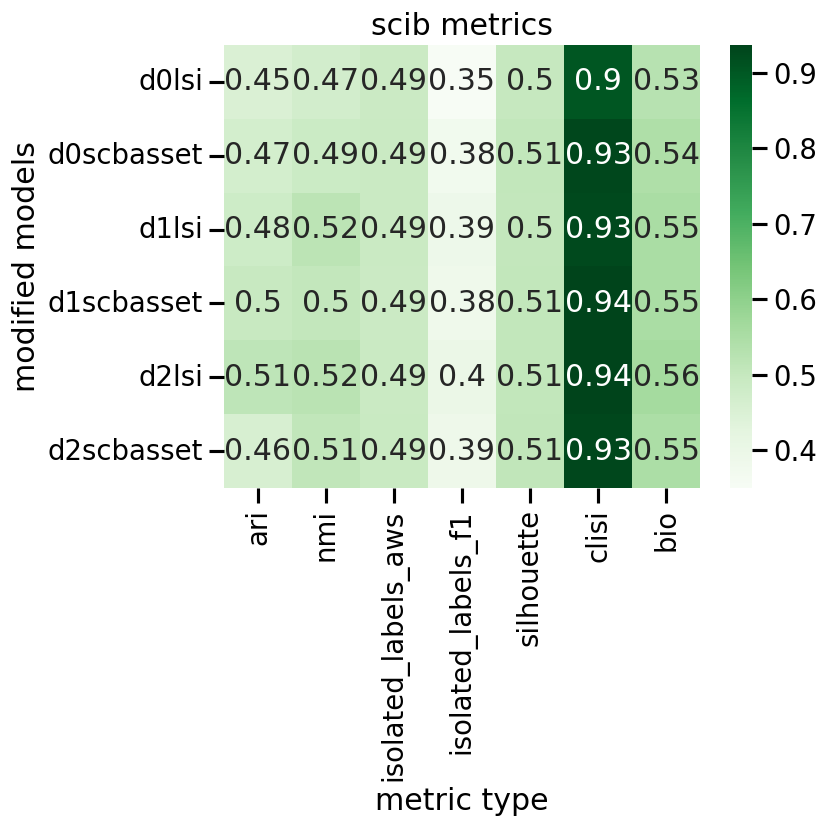

In [11]:
plt.figure(dpi=120)


sns.heatmap(data=bio_df,
           cmap=plt.get_cmap('Greens'),
           annot=True
           )

plt.title('scib metrics')
plt.xlabel('metric type')
plt.ylabel('modified models')
plt.savefig('Results/scib_heatmap_400epochs.png',bbox_inches='tight')